In [157]:
import mne
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm
import glob
from matplotlib import pyplot as plt
from scipy.stats import zscore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [158]:
_dfs_list = []
for csv_filename in tqdm(glob.glob('/Users/dmitrykorzhov/Desktop/Root/projects/bci_stuff/alcoholic_data_eeg/SMNI_CMI_TRAIN/*.csv')):
    _dfs_list.append(pd.read_csv(csv_filename))
df = pd.concat(_dfs_list)
del(_dfs_list)
df = df.drop(['Unnamed: 0'], axis=1)

100%|██████████| 468/468 [00:03<00:00, 149.06it/s]


In [159]:
_dfs_test_list = []
for csv_filename in tqdm(glob.glob('/Users/dmitrykorzhov/Desktop/Root/projects/bci_stuff/alcoholic_data_eeg/SMNI_CMI_TEST/*.csv')):
    _dfs_test_list.append(pd.read_csv(csv_filename))
df_test = pd.concat(_dfs_test_list)
del(_dfs_test_list)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

100%|██████████| 480/480 [00:03<00:00, 140.20it/s]


In [160]:
transposed_df_test_list = []

for group_df in tqdm(df_test.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
    _df = pd.DataFrame(group_df[1]['sensor value']).T
    _df.columns = [f'sample_{idx}' for idx in range(256)]
    _df['name'] = group_df[0][0]
    _df['trial number'] = group_df[0][1]
    _df['matching condition'] = group_df[0][2]
    _df['sensor position'] = group_df[0][3]
    _df['subject identifier'] = group_df[0][4]
    
    transposed_df_test_list.append(_df)
    
df_test = pd.concat(transposed_df_test_list)
df_test = df_test[[*df_test.columns[-5:],*df_test.columns[0:-5]]]
df_test = df_test.reset_index(drop=True)
df_test.head(3)

100%|██████████| 30720/30720 [00:13<00:00, 2285.83it/s]


,name,trial number,matching condition,sensor position,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,30,S1 obj,AF1,a,-6.083,-4.618,-2.177,1.241,2.706,...,3.194,0.753,-0.712,0.264,1.241,1.729,0.264,-1.689,-2.177,-0.224
1,co2a0000364,30,S1 obj,AF2,a,-7.640,-9.593,-7.151,0.173,8.962,...,2.614,0.661,0.661,1.149,2.126,1.149,-0.315,-1.780,-0.804,2.126
2,co2a0000364,30,S1 obj,AF7,a,-0.682,0.295,-1.170,-3.611,-5.564,...,5.666,3.225,3.713,6.154,7.131,5.178,0.783,-3.611,-4.100,1.272


In [161]:
transposed_df_list = []

for group_df in tqdm(df.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
    _df = pd.DataFrame(group_df[1]['sensor value']).T
    _df.columns = [f'sample_{idx}' for idx in range(256)]
    _df['name'] = group_df[0][0]
    _df['trial number'] = group_df[0][1]
    _df['matching condition'] = group_df[0][2]
    _df['sensor position'] = group_df[0][3]
    _df['subject identifier'] = group_df[0][4]
    
    transposed_df_list.append(_df)
    
df = pd.concat(transposed_df_list)
df = df[[*df.columns[-5:],*df.columns[0:-5]]]
df = df.reset_index(drop=True)
df.head(3)

100%|██████████| 29952/29952 [00:13<00:00, 2172.59it/s]


,name,trial number,matching condition,sensor position,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,0,S1 obj,AF1,a,-2.146,-2.146,-1.658,-0.682,2.248,...,-1.658,0.295,2.736,4.201,3.713,1.272,-0.682,-0.193,3.225,7.619
1,co2a0000364,0,S1 obj,AF2,a,1.129,0.641,-0.336,-0.824,0.641,...,4.059,-0.336,-2.777,-0.824,3.571,5.035,4.059,2.106,1.617,4.059
2,co2a0000364,0,S1 obj,AF7,a,-16.856,-7.090,7.558,19.277,23.183,...,17.324,9.511,1.699,-2.207,-2.207,1.211,5.117,8.046,10.000,11.464


In [162]:
sample_columns = [f'sample_{idx}' for idx in range(256)]
df[sample_columns] = df[sample_columns].apply(zscore, axis=0)


sample_columns_test = [f'sample_{idx}' for idx in range(256)]
df_test[sample_columns_test] = df_test[sample_columns_test].apply(zscore, axis=0)

In [163]:
def get_record_df(df, name, trial_number, matching_condition, channel_list):
    df_filtered = df[(df['name'] == name) & 
                     (df['trial number'] == trial_number) & 
                     (df['matching condition'] == matching_condition)]
    
    if df_filtered.empty:
        raise ValueError(f"No data found for name={name}, trial_number={trial_number}, matching_condition={matching_condition}")
    
    if df_filtered.index.name != 'sensor position':
        df_filtered = df_filtered.set_index('sensor position')
    
    try:
        df_record = df_filtered.loc[channel_list]
    except KeyError as e:
        missing_channels = [channel for channel in channel_list if channel not in df_filtered.index]
        raise KeyError(f"Missing channels in the index: {missing_channels}") from e
    
    return df_record


def get_signal_array(df, name, trial_number, matching_condition, channel_list):
    df_record = get_record_df(df, name, trial_number, matching_condition, channel_list)
    return df_record.to_numpy()[:, 4:]

In [164]:
sample_array = get_signal_array(df, 'co2a0000364', 0, 'S1 obj', df['sensor position'].unique())

In [165]:
class EEGDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with the data.
            transform (callable, optional): An optional transform to be applied to a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):

        return len(self.dataframe.groupby(['name', 'trial number']))

    def __getitem__(self, idx):

        unique_combinations = self.dataframe.groupby(['name', 'trial number']).size().reset_index().iloc[:, :2]
        name, trial_number = unique_combinations.iloc[idx]

        trial_data = self.dataframe[(self.dataframe['name'] == name) & (self.dataframe['trial number'] == trial_number)]

        signal_array = trial_data.iloc[:, 5:].to_numpy(dtype=np.float32)
        signal_tensor = torch.tensor(signal_array, dtype=torch.float)


        signal_tensor = signal_tensor.unsqueeze(1)

        if self.transform:
            signal_tensor = self.transform(signal_tensor)


        label = trial_data['subject identifier'].iloc[0]
        label = 1 if label == 'a' else 0  
        label_tensor = torch.tensor(label, dtype=torch.long)

        return signal_tensor, label_tensor

In [173]:
train_dataset = EEGDataset(dataframe=df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = EEGDataset(dataframe=df_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [167]:
for data, labels in train_loader:
    print("Shape of data (batch):", data.shape) 
    print("Shape of labels (batch):", labels.shape)  
    break  

Shape of data (batch): torch.Size([8, 64, 1, 256])
Shape of labels (batch): torch.Size([8])


In [168]:
labels_train = [labels for _, labels in train_loader]
labels_train = torch.cat(labels_train)
print("Distribution of labels in training set:", torch.bincount(labels_train))

labels_test = [labels for _, labels in test_loader]
labels_test = torch.cat(labels_test)
print("Distribution of labels in test set:", torch.bincount(labels_test))

Distribution of labels in training set: tensor([233, 235])
Distribution of labels in test set: tensor([240, 240])


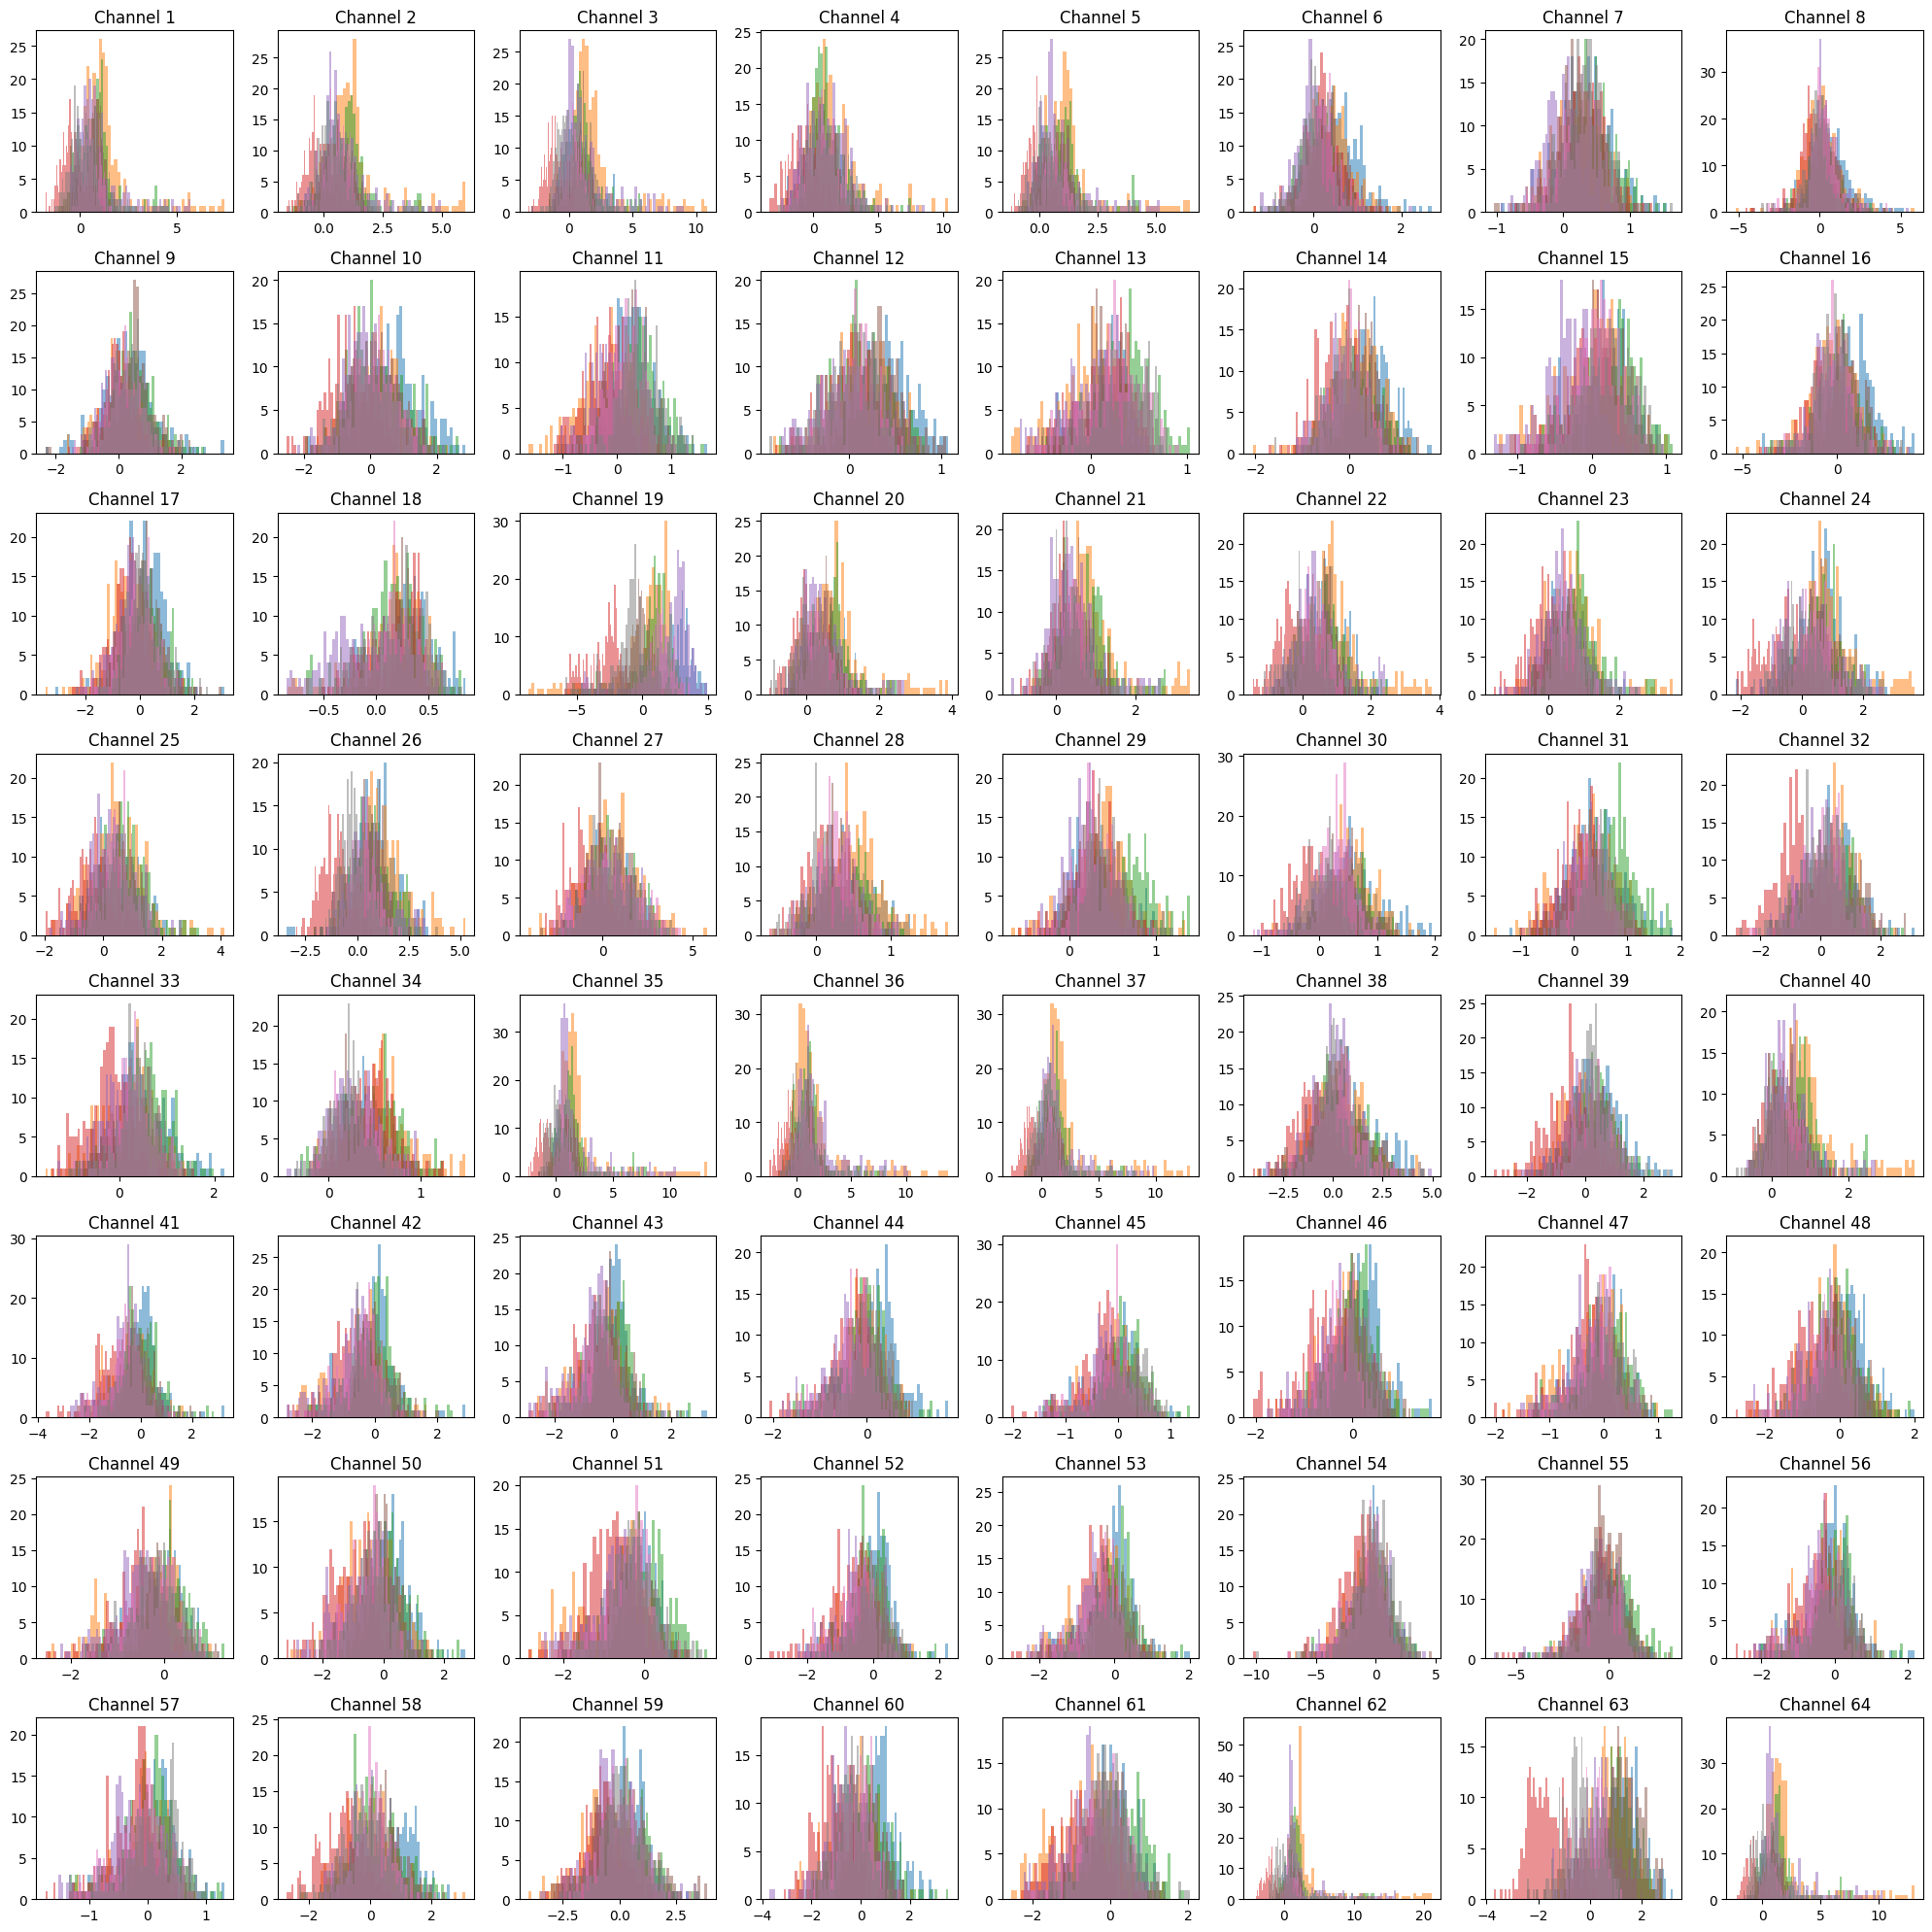

In [169]:
for data, labels in train_loader:

    data_np = data.numpy()
    
    fig, axs = plt.subplots(8, 8, figsize=(20, 20)) 
    axs = axs.flatten()
    for i in range(data_np.shape[1]):  
        for j in range(data_np.shape[0]):  
            axs[i].hist(data_np[j, i, 0, :], bins=50, alpha=0.5)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()
    
    break 

In [170]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  
        self.pool = nn.AdaptiveMaxPool2d((1, 128))
        self.dropout = nn.Dropout(0.5)  
        self.fc1 = nn.Linear(16384, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)

        x_fft = torch.fft.fft(torch.flatten(x, start_dim=1), dim=-1)
        x_amp = torch.abs(x_fft)
        x_log = torch.log(x_amp + 1e-9)

        x_flat = torch.flatten(x_log, start_dim=1)
        x = F.relu(self.fc1(x_flat))
        x = self.fc2(x)
        return x

In [171]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):

    train_losses = []
    test_losses = []  
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for data, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(data)  
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()  
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  
            for data, labels in test_loader:
                outputs = model(data)
                loss = criterion(outputs, labels.unsqueeze(1).float())  
                test_loss += loss.item() * data.size(0)
                predicted = (outputs > 0.5).float()  
                total += labels.size(0)
                correct += (predicted == labels.unsqueeze(1).float()).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss) 

        epoch_accuracy = correct / total
        test_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss (train): {epoch_loss:.4f}, Loss (test): {test_loss:.4f}')

    return train_losses, test_losses



In [174]:
model = EEGNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10)

Epoch 1, Loss (train): 2.4442, Loss (test): 0.6930
Epoch 2, Loss (train): 0.6932, Loss (test): 0.6931
Epoch 3, Loss (train): 0.7216, Loss (test): 0.6929
Epoch 4, Loss (train): 0.6932, Loss (test): 0.6931
Epoch 5, Loss (train): 0.6932, Loss (test): 0.6930
Epoch 6, Loss (train): 0.6932, Loss (test): 0.6931
Epoch 7, Loss (train): 0.6932, Loss (test): 0.6931
Epoch 8, Loss (train): 0.6932, Loss (test): 0.6931
Epoch 9, Loss (train): 0.6932, Loss (test): 0.6930
Epoch 10, Loss (train): 0.6932, Loss (test): 0.6930


In [175]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  
        for data, labels in test_loader:
            outputs = model(data)
            predicted = (outputs > 0.4).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    clf_report = classification_report(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(clf_report)
    print('Confusion Matrix:')
    print(conf_matrix)

In [176]:
evaluate_model(model, test_loader)

Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       240
           1       0.00      0.00      0.00       240

    accuracy                           0.50       480
   macro avg       0.25      0.50      0.33       480
weighted avg       0.25      0.50      0.33       480

Confusion Matrix:
[[240   0]
 [240   0]]


/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitrykorzhov/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,